# Entity Resolution project @ Wavestone
## Entity Matching - Zero shot

> *Datasets information from [here](https://data.dws.informatik.uni-mannheim.de/benchmarkmatchingtasks/index.html)*

> **Tristan PERROT**


## Import libraries


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda:0


In [3]:
while 'model' not in os.listdir():
    os.chdir('..')

In [4]:
MODEL_NAME = ''
DATA_NAME = 'amazon-google'
COMPUTER = 'gpu4.enst.fr:' + str(device)[-1:]
DATA_DIR = os.path.join('data', DATA_NAME)

## Pre-processing

In [5]:
import time

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch.nn as nn
from datasets import Dataset
from sentence_transformers import (CrossEncoder, InputExample,
                                   SentencesDataset, SentenceTransformer,
                                   SentenceTransformerTrainer,
                                   SentenceTransformerTrainingArguments,
                                   losses, util)
from sentence_transformers.cross_encoder.evaluation import \
    CEBinaryClassificationEvaluator
from sklearn.metrics import (classification_report, confusion_matrix, f1_score,
                             precision_score, recall_score, roc_auc_score,
                             roc_curve)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.mixture import GaussianMixture
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import DataLoader
from tqdm import tqdm

from model.utils import load_data

/home/jovyan/.local/lib/python3.10/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/conda/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
2025-02-06 16:02:08.304412: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS

In [6]:
table_a_serialized, table_b_serialized, X_train_ids, y_train, X_valid_ids, y_valid, X_test_ids, y_test = load_data(DATA_DIR, order_cols=True)

Table A columns:
    column_name data_example
1   description          NaN
2  manufacturer   broderbund
3         price          0.0 

Table B columns:
    column_name              data_example
1   description  learning quickbooks 2007
2  manufacturer                    intuit
3         price                     38.99 

Reordering columns
Table A columns order before: ['name' 'description' 'manufacturer' 'price']
Table B columns order before: ['name' 'description' 'manufacturer' 'price']
Table A columns order after: ['price' 'manufacturer' 'name' 'description']
Table B columns order after: ['price' 'manufacturer' 'name' 'description']
Serialized entities 



In [7]:
X1_train, X2_train = [table_a_serialized[i[0]] for i in X_train_ids], [table_b_serialized[i[1]] for i in X_train_ids]
X1_valid, X2_valid = [table_a_serialized[i[0]] for i in X_valid_ids], [table_b_serialized[i[1]] for i in X_valid_ids]
X1_test, X2_test = [table_a_serialized[i[0]] for i in X_test_ids], [table_b_serialized[i[1]] for i in X_test_ids]

In [8]:
# Display the first 5 samples of the training set
for i in range(5):
    print(f'Sample {i}:')
    print(f'Entity1: {X1_train[i]}')
    print(f'Entity2: {X2_train[i]}')
    print(f'Label: {y_train[i]}')
    print()

Sample 0:
Entity1: [COL] price [VAL] 229.99 [COL] manufacturer [VAL] microsoft [COL] name [VAL] microsoft powerpoint 2004 (mac) [COL] description [VAL] powerpoint 2004 offers you the powerful advanced new tools needed for fantastic presentations. whether it's for business academic or personal needs you'll design dynamic and visual presentations that stand out and get noticed.
Entity2: [COL] price [VAL] 109.95 [COL] manufacturer [VAL]  [COL] name [VAL] microsoft office outlook 2007 [COL] description [VAL] key features: manages time and info works with sharepoint enhanced search one-click functionality create internet calendars enhanced security ...
Label: 0

Sample 1:
Entity1: [COL] price [VAL] 499.99 [COL] manufacturer [VAL] sage software [COL] name [VAL] peachtree by sage premium accounting 2007 - accountants' edition [COL] description [VAL] peachtree premium accounting 2007 accountants' edition is the powerful multi-user ready accounting solution accountants need to service their pea

## Zero Shot Prediction

In [18]:
MODEL_NAME = 'all-mpnet-base-v2'

In [19]:
model = SentenceTransformer(MODEL_NAME, device=device)

In [20]:
embedding1_test = model.encode(X1_test, show_progress_bar=True)
embedding2_test = model.encode(X2_test, show_progress_bar=True)

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

In [21]:
similarity_test_zero = cosine_similarity(embedding1_test, embedding2_test)

In [22]:
print(similarity_test_zero.shape)

(836, 836)


In [23]:
# Set a similarity threshold
threshold = 0.70

y_pred = np.zeros_like(y_test)

for i in range(len(y_test)):
    if similarity_test_zero[i,i] > threshold:
        y_pred[i] = 1


# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.91      0.93       708
           1       0.58      0.70      0.64       128

    accuracy                           0.88       836
   macro avg       0.76      0.81      0.78       836
weighted avg       0.89      0.88      0.88       836



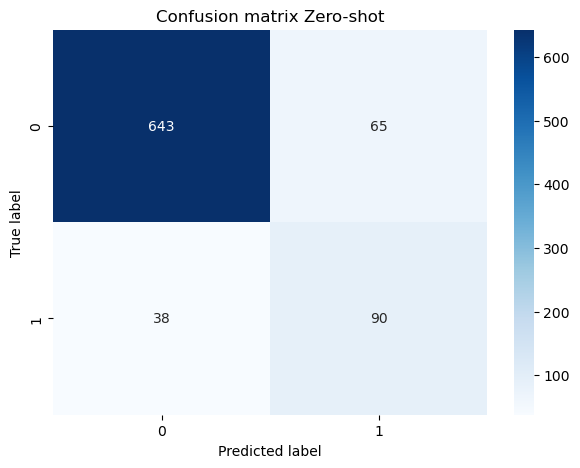

In [24]:
# Confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix Zero-shot')
plt.show()

## Few Shot Prediction

In [9]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
print(os.environ['CUDA_VISIBLE_DEVICES'])

0


In [10]:
MODEL_NAME = 'sentence-transformers/multi-qa-mpnet-base-dot-v1'

EPOCHS = 5
WEIGHT_DECAY = 0.01
LEARNING_RATE = 5e-5
BATCH_SIZE = 16
ADAM_EPSILON = 1e-8

TRUE_SAMPLES_SIZE = 5
FALSE_SAMPLES_SIZE = 5

In [11]:
model = SentenceTransformer(MODEL_NAME, device=device)

In [12]:
# Select 50 true sample and 50 false samples
y_train_np = np.array(y_train)
true_samples = np.nonzero(y_train_np)[0]
false_samples = np.nonzero(1-y_train_np)[0]

np.random.seed(0)
true_samples = np.random.choice(true_samples,TRUE_SAMPLES_SIZE)
false_samples = np.random.choice(false_samples,FALSE_SAMPLES_SIZE)

X1_train_sample = [X1_train[i] for i in true_samples] + [X1_train[i] for i in false_samples]
X2_train_sample = [X2_train[i] for i in true_samples] + [X2_train[i] for i in false_samples]
y_train_sample = [1]*TRUE_SAMPLES_SIZE + [0]*FALSE_SAMPLES_SIZE


dataset = Dataset.from_dict({
    'sentence1': X1_train_sample,
    'sentence2': X2_train_sample,
    'label': y_train_sample
})

train_dataloader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=0)

train_loss = losses.CosineSimilarityLoss(model)

warmup_steps = int(len(train_dataloader) * EPOCHS * 0.1)

model_path = os.path.join('model', 'cross_encoder', DATA_NAME, MODEL_NAME)

training_args = SentenceTransformerTrainingArguments(
    output_dir=model_path,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=1,
    warmup_steps=warmup_steps,
    weight_decay=WEIGHT_DECAY,
    learning_rate=LEARNING_RATE,
    adam_epsilon=ADAM_EPSILON,
    max_grad_norm=1.0,
    overwrite_output_dir=True
)

trainer = SentenceTransformerTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    loss=train_loss
)

trainer.train()

Step,Training Loss


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

TrainOutput(global_step=5, training_loss=0.08901935815811157, metrics={'train_runtime': 6.0351, 'train_samples_per_second': 8.285, 'train_steps_per_second': 0.828, 'total_flos': 0.0, 'train_loss': 0.08901935815811157, 'epoch': 5.0})

In [13]:
embedding1_test = model.encode(X1_test, show_progress_bar=True)
embedding2_test = model.encode(X2_test, show_progress_bar=True)

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

In [14]:
similarity_test_few = cosine_similarity(embedding1_test, embedding2_test)

In [15]:
# Set a similarity threshold
threshold = 0.70

y_pred = np.zeros_like(y_test)

for i in range(len(y_test)):
    if similarity_test_few[i,i] > threshold:
        y_pred[i] = 1


# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       708
           1       0.62      0.66      0.64       128

    accuracy                           0.89       836
   macro avg       0.78      0.79      0.79       836
weighted avg       0.89      0.89      0.89       836



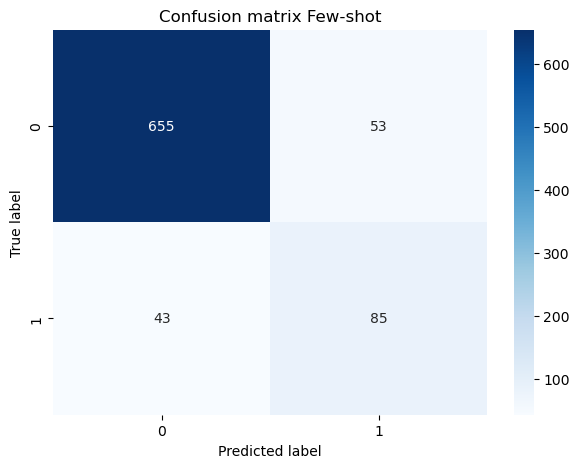

In [16]:
# Confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix Few-shot')
plt.show()

## Few Shot Prediction v2

In [26]:
from model.CrossEncoderModel import fit_cross_encoder, prepare_data_cross_encoder, evaluate_cross_encoder

import time

import torch.nn as nn
from sentence_transformers import CrossEncoder, InputExample
from sentence_transformers.cross_encoder.evaluation import \
    CEBinaryClassificationEvaluator
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import DataLoader
from tqdm import tqdm

from model.utils import load_data

MODEL_NAME = 'cross-encoder/stsb-roberta-base'


train_loader, valid_set, y_valid, test_examples, X_test_ids, y_test = prepare_data_cross_encoder(DATA_DIR, remove_col_names=False, order_cols=True, true_samples_size=TRUE_SAMPLES_SIZE, false_samples_size=FALSE_SAMPLES_SIZE)

WARMUP_STEPS = int(len(train_loader) * EPOCHS * 0.1)

logits, training_time = fit_cross_encoder(MODEL_NAME, train_loader, valid_set, y_valid,
                                        test_examples, epochs=EPOCHS, learning_rate=LEARNING_RATE,
                                        weight_decay=WEIGHT_DECAY, warmup_steps=WARMUP_STEPS,
                                        classifier_dropout=None)

accuracy, precision, recall, f1, roc_auc = evaluate_cross_encoder(logits, y_test, threshold=threshold)

ImportError: cannot import name 'CrossEncoderModel' from 'model' (unknown location)

Max F1 score: 0.6565349544072948 at threshold 0.6565656565656566
Max F1 score: 0.6459143968871596 at threshold 0.7171717171717172


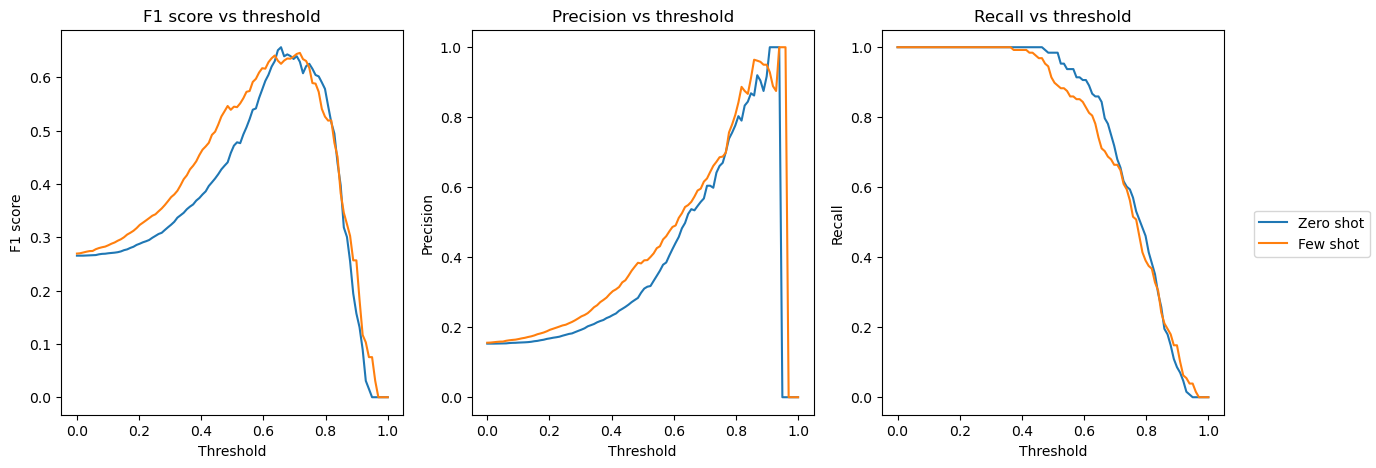

In [25]:
f1_scores_zero = []
precisions_zero = []
recalls_zero = []
thresholds = np.linspace(0, 1, 100)
for threshold in thresholds:
    y_pred = np.zeros_like(y_test)
    for i in range(len(y_test)):
        if similarity_test_zero[i,i] > threshold:
            y_pred[i] = 1
    f1_scores_zero.append(f1_score(y_test, y_pred, zero_division=0))
    precisions_zero.append(precision_score(y_test, y_pred, zero_division=0))
    recalls_zero.append(recall_score(y_test, y_pred, zero_division=0))

max_f1_score_zero = max(f1_scores_zero)
best_threshold_zero = thresholds[f1_scores_zero.index(max_f1_score_zero)]
print(f'Max F1 score: {max_f1_score_zero} at threshold {best_threshold_zero}')

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(thresholds, f1_scores_zero)
ax[0].set_title('F1 score vs threshold')
ax[0].set_xlabel('Threshold')
ax[0].set_ylabel('F1 score')
ax[1].plot(thresholds, precisions_zero)
ax[1].set_title('Precision vs threshold')
ax[1].set_xlabel('Threshold')
ax[1].set_ylabel('Precision')
ax[2].plot(thresholds, recalls_zero)
ax[2].set_title('Recall vs threshold')
ax[2].set_xlabel('Threshold')
ax[2].set_ylabel('Recall')

f1_scores_few = []
precisions_few = []
recalls_few = []
thresholds = np.linspace(0, 1, 100)
for threshold in thresholds:
    y_pred = np.zeros_like(y_test)
    for i in range(len(y_test)):
        if similarity_test_few[i,i] > threshold:
            y_pred[i] = 1
    f1_scores_few.append(f1_score(y_test, y_pred, zero_division=0))
    precisions_few.append(precision_score(y_test, y_pred, zero_division=0))
    recalls_few.append(recall_score(y_test, y_pred, zero_division=0))

max_f1_score_few = max(f1_scores_few)
best_threshold_few = thresholds[f1_scores_few.index(max_f1_score_few)]
print(f'Max F1 score: {max_f1_score_few} at threshold {best_threshold_few}')

ax[0].plot(thresholds, f1_scores_few)
ax[1].plot(thresholds, precisions_few)
ax[2].plot(thresholds, recalls_few)

fig.legend(['Zero shot', 'Few shot'], loc='center right')
plt.show()